In [2]:
#CV project

In [3]:
!pip install anomalib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.6/486.6 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.3/216.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 28.6 MB/s eta 0:00:00


In [59]:
# !pip install open-clip-torch


In [60]:
# !pip install --upgrade anomalib


In [25]:
import anomalib
print(anomalib.__version__)


1.2.0


In [28]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from tqdm.notebook import tqdm
from datetime import datetime
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve


In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)} (CUDA {torch.version.cuda})")
else:
    device = torch.device("cpu")
    print("No GPU detected, using CPU")

GPU: Tesla P100-PCIE-16GB (CUDA 12.1)


In [34]:
from anomalib.data import MVTec
from anomalib.models import Patchcore
#from anomalib.post_processing import Visualizer, VisualizationMode

from anomalib.deploy import TorchInferencer

In [36]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [43]:
import os

DATASET_PATH = "/kaggle/input/mvtec-ad"
print("Dataset exists:", os.path.exists(DATASET_PATH))

if os.path.exists(DATASET_PATH):
    print("Available categories:", os.listdir(DATASET_PATH))
else:
    print("Dataset folder not found. Check if it is correctly added in Kaggle.")


Dataset exists: True
Available categories: ['wood', 'screw', 'metal_nut', 'capsule', 'readme.txt', 'hazelnut', 'carpet', 'pill', 'license.txt', 'grid', 'zipper', 'transistor', 'tile', 'leather', 'toothbrush', 'bottle', 'cable']


In [45]:
# categories = sorted(os.listdir(DATASET_PATH))
# print(f"Available categories: {categories}")

Available categories: ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'license.txt', 'metal_nut', 'pill', 'readme.txt', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']


In [47]:
categories = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))]
print(f"Available categories: {categories}")

def get_anomaly_types(category):
    anomaly_dir = os.path.join(DATASET_PATH, category, "test")
    return [d for d in os.listdir(anomaly_dir) if os.path.isdir(os.path.join(anomaly_dir, d)) and d != "good"]

for category in categories:
    anomaly_types = get_anomaly_types(category)
    print(f"Category '{category}' has anomaly types: {anomaly_types}")

Available categories: ['wood', 'screw', 'metal_nut', 'capsule', 'hazelnut', 'carpet', 'pill', 'grid', 'zipper', 'transistor', 'tile', 'leather', 'toothbrush', 'bottle', 'cable']
Category 'wood' has anomaly types: ['hole', 'liquid', 'scratch', 'color', 'combined']
Category 'screw' has anomaly types: ['thread_top', 'scratch_neck', 'thread_side', 'scratch_head', 'manipulated_front']
Category 'metal_nut' has anomaly types: ['bent', 'flip', 'scratch', 'color']
Category 'capsule' has anomaly types: ['poke', 'squeeze', 'faulty_imprint', 'scratch', 'crack']
Category 'hazelnut' has anomaly types: ['cut', 'print', 'hole', 'crack']
Category 'carpet' has anomaly types: ['thread', 'metal_contamination', 'cut', 'hole', 'color']
Category 'pill' has anomaly types: ['contamination', 'pill_type', 'faulty_imprint', 'scratch', 'color', 'crack', 'combined']
Category 'grid' has anomaly types: ['thread', 'broken', 'glue', 'metal_contamination', 'bent']
Category 'zipper' has anomaly types: ['squeezed_teeth', 

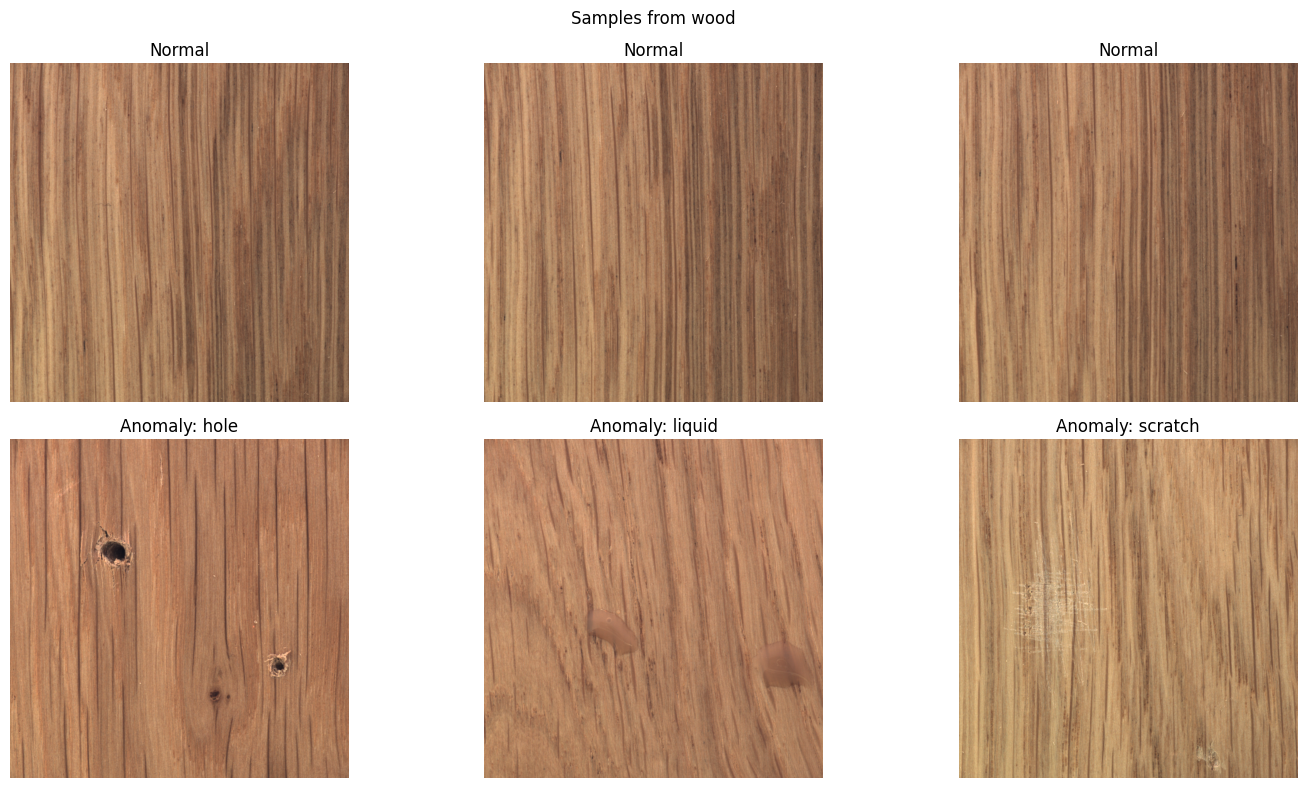

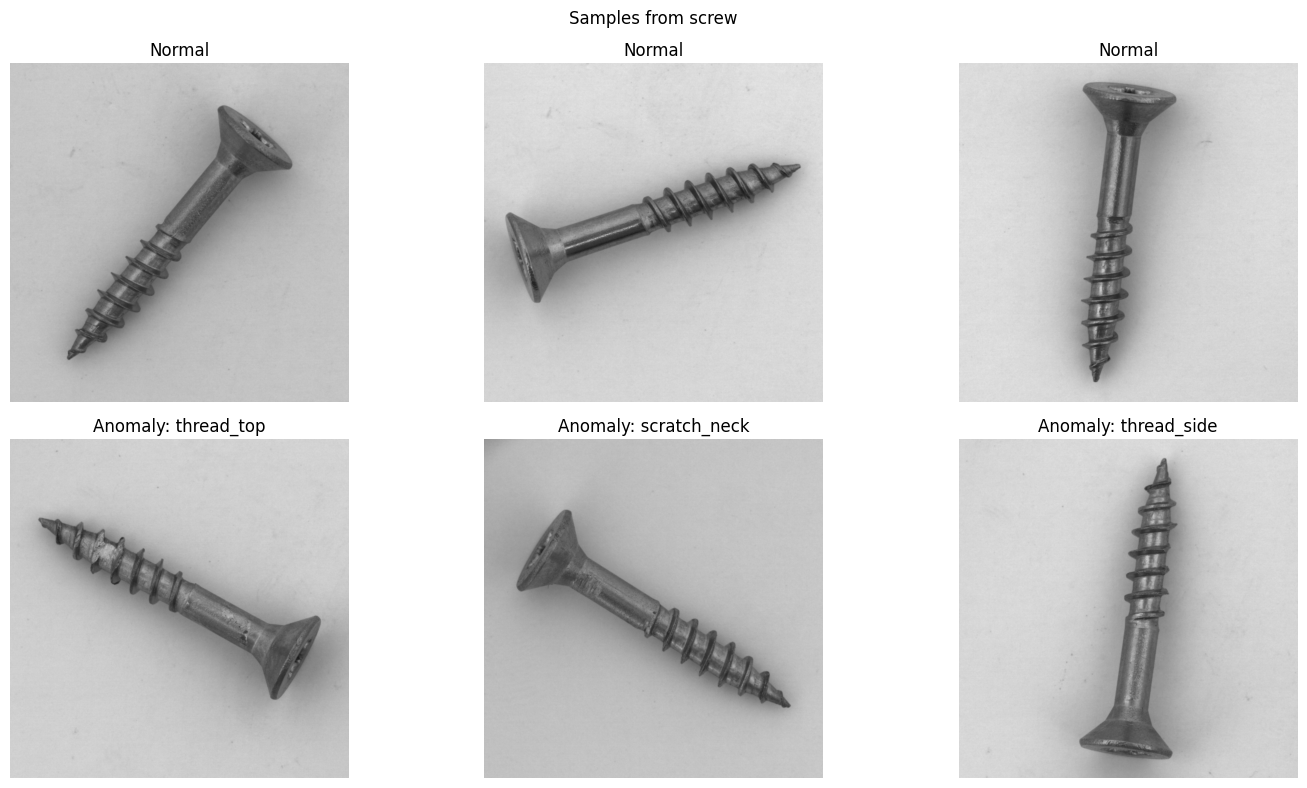

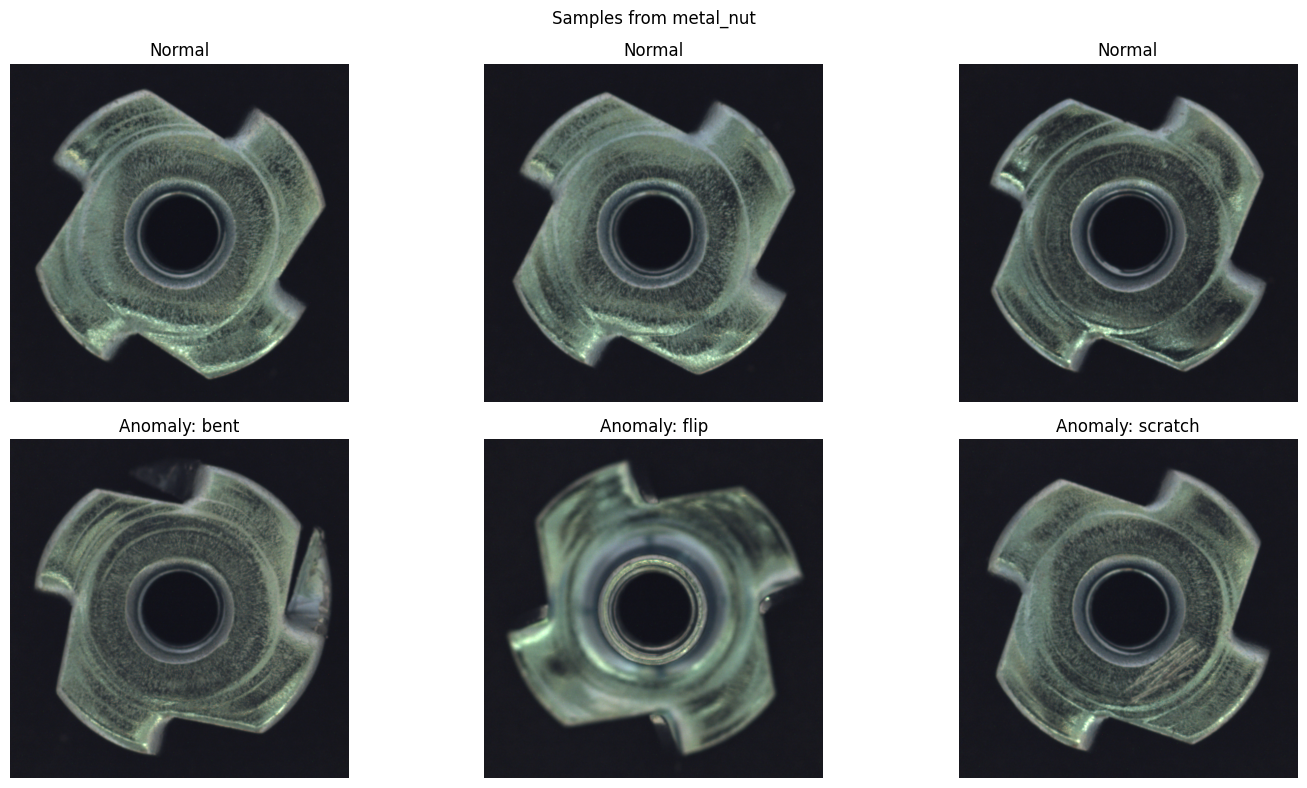

In [52]:
def visualize_samples(category, num_samples=3):
    # Normal samples
    normal_dir = os.path.join(DATASET_PATH, category, "train", "good")
    normal_files = sorted(os.listdir(normal_dir))[:num_samples]
    
    anomaly_types = get_anomaly_types(category)
    anomaly_samples = []
    anomaly_labels = []
    
    for anomaly_type in anomaly_types[:min(num_samples, len(anomaly_types))]:
        anomaly_dir = os.path.join(DATASET_PATH, category, "test", anomaly_type)
        anomaly_files = sorted(os.listdir(anomaly_dir))
        if anomaly_files:
            anomaly_samples.append(os.path.join(anomaly_dir, anomaly_files[0]))
            anomaly_labels.append(anomaly_type)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))

    for i, file in enumerate(normal_files):
        img = cv2.imread(os.path.join(normal_dir, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[0, i].imshow(img)
        axes[0, i].set_title("Normal")
        axes[0, i].axis('off')
    
    # Plot anomaly samples
    for i, (file, label) in enumerate(zip(anomaly_samples, anomaly_labels)):
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[1, i].imshow(img)
        axes[1, i].set_title(f"Anomaly: {label}")
        axes[1, i].axis('off')
    
    plt.suptitle(f"Samples from {category}")
    plt.tight_layout()
    plt.show()

for category in categories[:3]: 
    visualize_samples(category)

In [54]:
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32

In [62]:
import numpy as np
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader

from anomalib import TaskType
from anomalib.data import MVTec, PredictDataset
from anomalib.engine import Engine
from anomalib.models import Fastflow, Ganomaly
from anomalib.utils.post_processing import superimpose_anomaly_map
from lightning.pytorch.strategies import DDPStrategy

In [64]:
task = TaskType.SEGMENTATION

In [66]:
from pathlib import Path

dataset_root = Path.cwd().parent / "datasets" / "MVTec"

In [67]:
datamodule = MVTec(
    root=dataset_root,  
    # category="bottle",
    image_size=256,     
    train_batch_size=16,  
    eval_batch_size=16,   
    num_workers=8,        
)

patchcore

In [68]:
import wandb
import torch
import glob
import numpy as np
import pandas as pd
import albumentations as A
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from functools import partial
from matplotlib.figure import Figure
from typing import Dict, Optional, Tuple, Union

from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import Trainer, LightningModule, seed_everything
from pytorch_lightning.core.datamodule import LightningDataModule
from pytorch_lightning.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS

In [69]:
from anomalib.models import Patchcore

In [70]:
config = {
    
    "dataset": "metal_nut",

    "params_dataset": {
        "image_size": 224,
        "train_batch_size": 32,
        "test_batch_size": 32,
        "num_workers": 4,
        "transform_config": {
            "train": None,
            "val": None
        },
        "test_size": 0.5,
        "seed": 2022,
        "task": "segmentation"
    },

    "params_augmentation": {
        "MedianBlur": {
            "blur_limit": 7,
            "p": 0.
        },
        "RandomBrightnessContrast": {
            "brightness_limit": 0.1,
            "contrast_limit": 0.0,
            "p": 0.  
        }   
    },

    "params_model": {
        "input_size": 224,
        "backbone": "wide_resnet50_2",
        "pre_trained": True,
        "layers": [
            "layer2",
            "layer3"
        ],
        "coreset_sampling_ratio": 0.1,
        "num_neighbors": 9,
    },

    "params_metrics": { 
        "image": ["F1Score", "AUROC", "AUPR"],
        "pixel": ["F1Score", "AUROC", "AUPR"],
        "threshold": {
            "method": "adaptive", # options: [adaptive, manual]
            "manual_image": None,
            "manual_pixel": None
      },
      "task": "segmentation"
    },

    "params_trainer": {
        "accelerator": "auto",
        "check_val_every_n_epoch": 1,
        "max_epochs": 1,
        "max_steps": -1,
        "num_sanity_val_steps": 0,
        "val_check_interval": 1.0 
    },

    "params_threshold": {
        "quantile": 0.9
    },
    
    "seed": 42
     
}

In [79]:
import wandb
wandb_key = "d2901adcf22793f68be2e5c48278574697aa77f5"  

wandb.login(key=wandb_key)
wandb_run = wandb.init(config=config, project="notebook-anomalib")
print("Weights & Biases run initialized successfully!")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Weights & Biases run initialized successfully!


In [81]:
from pathlib import Path
from anomalib import TaskType
from anomalib.data import MVTec
from anomalib.engine import Engine
from anomalib.models import Patchcore
from anomalib.utils.post_processing import superimpose_anomaly_map
import numpy as np
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader

In [82]:
dataset_root = Path.cwd().parent / "datasets" / "MVTec"

model = Patchcore(
    backbone="wide_resnet50_2",
    pre_trained=True,
    coreset_sampling_ratio=0.1,
    num_neighbors=9
)

IMAGE_SIZE = (256, 256)

datamodule = MVTec(
    root=dataset_root,
    # category="bottle", 
    image_size=IMAGE_SIZE,  
    train_batch_size=16,
    eval_batch_size=16,
    num_workers=8,
)

callbacks = [
    ModelCheckpoint(
        mode="max",
        monitor="image_AUROC",
    ),
    EarlyStopping(
        monitor="image_AUROC",
        mode="max",
        patience=3,
    ),
]

engine = Engine(
    callbacks=callbacks,
    pixel_metrics="AUROC",
    accelerator="auto",
    devices='auto',
    logger=True,
)

engine.fit(datamodule=datamodule, model=model)

model.safetensors:   0%|          | 0.00/276M [00:00<?, ?B/s]

mvtec: 5.26GB [04:02, 21.7MB/s]                                
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
INFO: 
  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | PatchcoreModel           | 24.9 M | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MetricCollection         | 0      | train
3 | image_threshold       | F1AdaptiveThreshold      | 0      | train
4 | pixel_threshold       | F1AdaptiveThreshold      | 0      | train
5 | image_metrics         | AnomalibMetricCollection | 0      | train
6 | pixel_metrics         | AnomalibMetricCollection | 0      | train
------------------------------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/optimization/automatic.py:134: `training_step` returned `None`. If this was on purpose, ignore this warning...


Validation: |          | 0/? [00:00<?, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/16385 [00:00<?, ?it/s]

Selecting Coreset Indices.:   0%|          | 1/16385 [00:00<1:11:38,  3.81it/s]

Selecting Coreset Indices.:   0%|          | 12/16385 [00:00<06:43, 40.55it/s] 

Selecting Coreset Indices.:   0%|          | 42/16385 [00:00<02:09, 126.45it/s]

Selecting Coreset Indices.:   1%|          | 86/16385 [00:00<01:11, 226.61it/s]

Selecting Coreset Indices.:   1%|          | 128/16385 [00:00<00:56, 287.16it/s]

Selecting Coreset Indices.:   1%|          | 161/16385 [00:00<00:56, 287.84it/s]

Selecting Coreset Indices.:   1%|          | 193/16385 [00:00<00:55, 292.30it/s]

Selecting Coreset Indices.:   1%|▏         | 226/16385 [00:00<00:53, 301.79it/s]

Selecting Coreset Indices.:   2%|▏         | 265/16385 [00:01<00:49, 325.91it/s]

Selecting Coreset Indices.:   2%|▏         | 303/16385 [00:01<00:47, 341.51it/s]

Selecting Coreset Indices.:   2%|▏         | 338/16385 [00:01<00:50, 320.44it/s]

Selecting Coreset Indices.:  

In [83]:
test_results = engine.test(
    model=model,
    datamodule=datamodule,
    ckpt_path=engine.trainer.checkpoint_callback.best_model_path,
)

/usr/local/lib/python3.10/dist-packages/anomalib/engine/engine.py:391: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=model.de

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │            1.0            │
│       image_F1Score       │    0.9919999837875366     │
│        pixel_AUROC        │     0.981537938117981     │
└───────────────────────────┴───────────────────────────┘

In [84]:
from anomalib.data import MVTec, PredictDataset


inference_dataset = PredictDataset(path='/kaggle/input/mvtec-ad/bottle/test/broken_large/001.png')
inference_dataloader = DataLoader(dataset=inference_dataset)

In [85]:
import time

start=time.time()
predictions = engine.predict(model=model, dataloaders=inference_dataloader)[0]
end=time.time()
print(f"Inference time {end-start}")

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Inference time 0.5461399555206299


In [86]:
predictions

{'image': tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
           [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
           [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
           ...,
           [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
           [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
           [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],
 
          [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
           [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
           [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
           ...,
           [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
           [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
           [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],
 
          [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
           [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
           [2.6

In [89]:
print(
    f'Image Shape: {predictions["image"].shape},\n'
    f'Anomaly Map Shape: {predictions["anomaly_maps"].shape},\n'
    f'Predicted Mask Shape: {predictions["pred_masks"].shape}'
)


Image Shape: torch.Size([1, 3, 224, 224]),
Anomaly Map Shape: torch.Size([1, 1, 224, 224]),
Predicted Mask Shape: torch.Size([1, 1, 224, 224])


In [91]:
image_path = predictions["image_path"][0]
image_size = predictions["image"].shape[-2:]
image = np.array(Image.open(image_path).resize(image_size))
plt.imshow(image)
plt.show()  

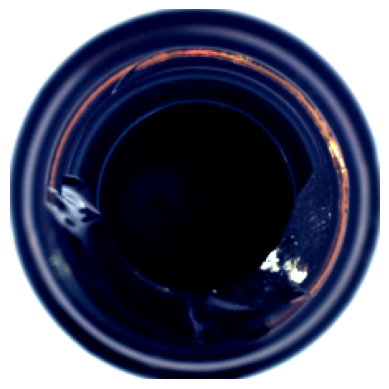

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Extract the first image tensor
image_tensor = predictions["image"][0]  # Shape: (C, H, W) or (H, W, C)

# Convert PyTorch tensor to NumPy
if isinstance(image_tensor, torch.Tensor):
    image = image_tensor.detach().cpu().numpy()
else:
    image = np.array(image_tensor)

# Handle different formats (C, H, W) → (H, W, C)
if image.shape[0] in [1, 3]:  # If channel-first
    image = np.transpose(image, (1, 2, 0))  # Convert to (H, W, C)

# Normalize if values are in [0,1] or [-1,1]
if image.min() < 0:  # If in range [-1,1], rescale to [0,255]
    image = (image + 1) / 2  
if image.max() <= 1.0:  # If in range [0,1], rescale to [0,255]
    image = (image * 255).astype(np.uint8)

# Convert grayscale images to 3-channel RGB
if image.shape[-1] == 1:
    image = np.repeat(image, 3, axis=-1)  # Convert (H, W, 1) → (H, W, 3)

# Display the image
plt.imshow(image)
plt.axis("off")  # Remove axes
plt.show()


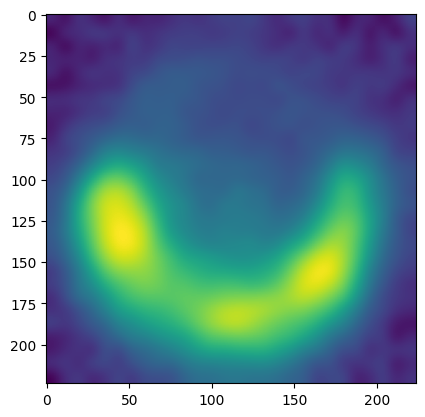

In [92]:
%matplotlib inline

anomaly_map = predictions["anomaly_maps"][0]
anomaly_map = anomaly_map.cpu().numpy().squeeze()
plt.imshow(anomaly_map)
plt.show() 

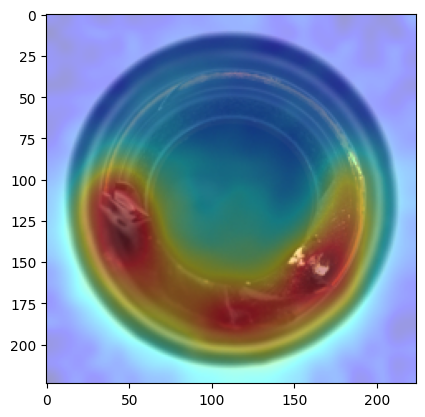

In [93]:
heat_map = superimpose_anomaly_map(anomaly_map=anomaly_map, image=image, normalize=True)
plt.imshow(heat_map)
plt.show()

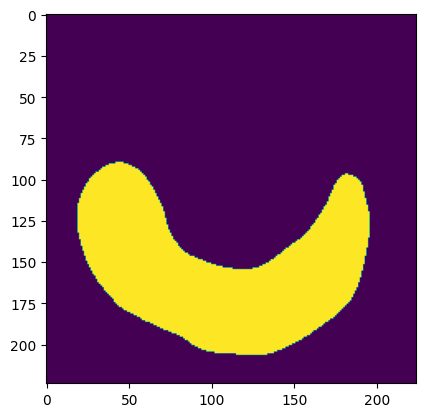

In [94]:
pred_masks = predictions["pred_masks"][0].squeeze().cpu().numpy()
plt.imshow(pred_masks)

In [95]:
pred_score = predictions["pred_scores"][0]
pred_labels = predictions["pred_labels"][0]
print(pred_score, pred_labels)

tensor(0.9321) tensor(True)
